In [1]:
import warnings
import unittest
from prefixspan import PrefixSpan
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import re
import string
import os
import time
import resource
import matplotlib.pyplot as plt


warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
nltk.download('stopwords')
nltk.download('punkt')
factory = StemmerFactory()
stemmer = factory.create_stemmer()
listStopword =  set(stopwords.words('indonesian')) 

listtoberemoved = ['bengkulu', 'and', 'of', 'on','in','based','the','to','indonesia','thailand','from', 'for','berbasis','muara','bangkahulu','kota','di','untuk','lempuing']

Matplotlib is building the font cache; this may take a moment.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jpawitro/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/jpawitro/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
def memory_limit():
    soft, hard = resource.getrlimit(resource.RLIMIT_AS)
    resource.setrlimit(resource.RLIMIT_AS, (get_memory() * int(1024 / 2), hard))

def get_memory():
    with open('/proc/meminfo', 'r') as mem:
        free_memory = 0
        for i in mem:
            sline = i.split()
            if str(sline[0]) in ('MemFree:', 'Buffers:', 'Cached:'):
                free_memory += int(sline[1])
    return free_memory

In [3]:
def read_data(x):
    XL = pd.ExcelFile(os.path.join("data","data_mod.xlsx"))
    sheet = XL.sheet_names[x]
    data = pd.read_excel(XL, sheet)
    data = data[~data['Topik'].isnull()]
    data['Tahun'] = data['Tahun'].astype(int)
    data = data.reset_index(drop=True)
    data = data[data.columns.tolist()[:-3]].join(data[data.columns.tolist()[-2:]]).join(data[data.columns.tolist()[-3]])
    return data, sheet

def preprocessing(data, listtoberemoved):
    df = pd.DataFrame(data['Judul'],columns=['Judul']).copy()
    cleaned = []
    for n in df['Judul'].values:
        n = n.lower()
        n = re.sub(r':', '', n)
        n = re.sub(r'‚Ä¶', '', n)
        n = re.sub(r'[^\x00-\x7F]+',' ', n)
        n = re.sub('[^a-zA-Z]', ' ', n)
        n = re.sub("&lt;/?.*?&gt;","&lt;&gt;",n)
        n = re.sub("(\\d|\\W)+"," ",n)
        n = re.sub(r'â', '', n)
        n = re.sub(r'€', '', n)
        n = re.sub(r'¦', '', n)
        cleaned.append(n)
    df['cleaned'] = cleaned

    tokenized = []
    for n in cleaned:
        n = word_tokenize(n)
        tokenized.append(n)
    df['tokenized'] = [', '.join(n) for n in tokenized]

    removed = []
    for ts in tokenized:
        n = []
        for t in ts:
            if t not in listtoberemoved and t not in listStopword and t not in string.punctuation:
                n.append(t)
        removed.append(n)
    df['removed'] = [', '.join(n) for n in removed]

    stemmed = []
    for n in removed:
        n = ' '.join(n)
        n = stemmer.stem(n)
        n = n.split(' ')
        stemmed.append(n)
    df['stemmed'] = [' '.join(n) for n in stemmed]
    return df, stemmed

def mining(data,stemmed, ms, mp, mnp):

    dx = [n for n in [a + b + c for a,b,c in zip(stemmed,data['Keyword'].str.split(",").values.tolist(),data['Topik'].str.split(",").values.tolist())]]
    ps = PrefixSpan(dx)
    pf_results = pd.DataFrame(ps.frequent(ms), columns=['freq','sequence'])
    
    pf_results['sequence'] = [', '.join(n) for n in pf_results['sequence'].values.tolist()]
    pf_results = pf_results[[len(n)<=mp for n in pf_results['sequence'].str.split(",").values.tolist()]]
    pf_results = pf_results[[len(n)>=mnp for n in pf_results['sequence'].str.split(",").values.tolist()]].sort_values(by='freq',ascending=False).reset_index(drop=True)
    return pf_results

def run(seq,ms,mp,mnp):
    data, sheet= read_data(seq)
    df, stemmed = preprocessing(data, listtoberemoved)
    pf = mining(data, stemmed, ms=ms, mp=mp, mnp=mnp)
    return pf

In [4]:

memory_limit()

In [5]:
report = []
for i,jur in enumerate(["Informatika","Sipil","Mesin","Elektro","Arsitektur","Sistem Informasi"]):
    for j in range(2,7):
        start_time = time.time()
        if jur=="Mesin" and j == 2:
            continue
        else:
            try:
                run(i+1,j,10,3)
            except MemoryError:
                print("Memory Insufficient")
                continue
        # print(jur,j,time.time() - start_time, get_memory())
        report.append([jur,j,time.time() - start_time, get_memory()])

df_report = pd.DataFrame(report, columns=["data","min support","running time (s)", "memory usage (kB)"])

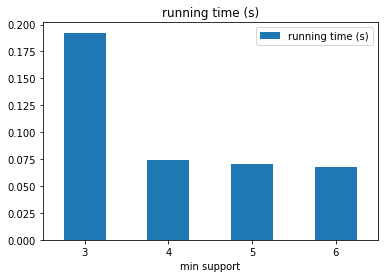

In [6]:
df_report[["data","min support","running time (s)"]][df_report["data"]=="Mesin"].set_index("min support").plot.bar(rot=0, subplots=True)
plt.show()

In [7]:
min(df_report["running time (s)"])

0.0550999641418457

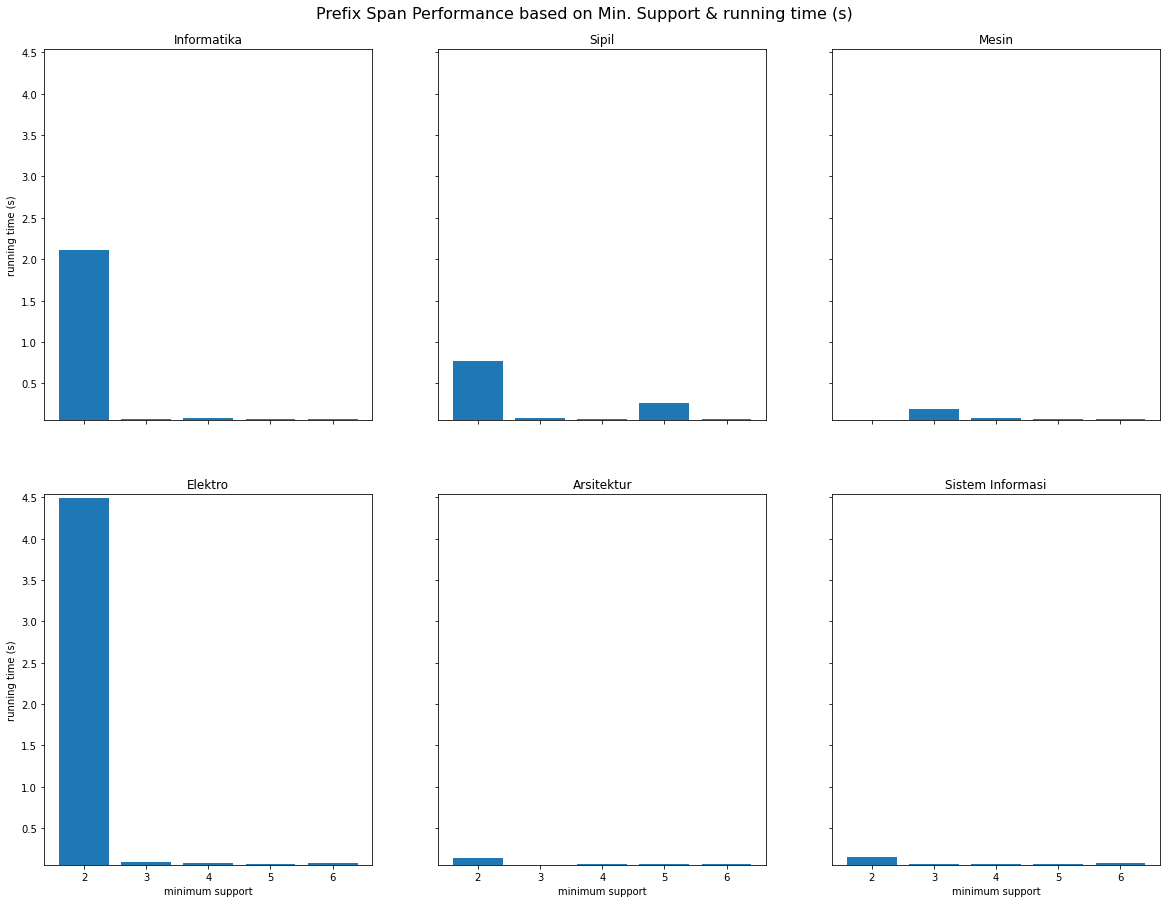

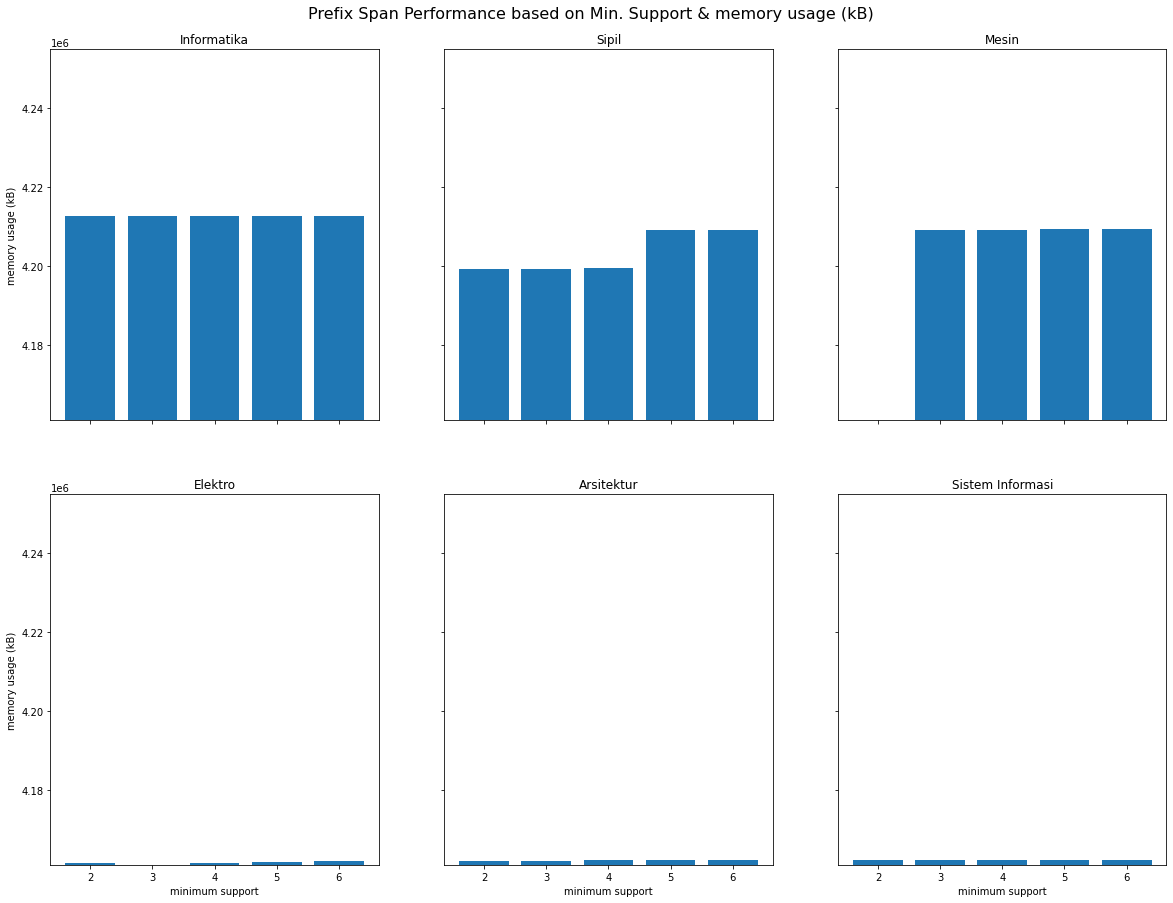

In [8]:
for h in ["running time (s)","memory usage (kB)"]:
    fig, axs = plt.subplots(2, 3,figsize = (20,15), sharex=True)
    for i,jur in enumerate(["Informatika","Sipil","Mesin","Elektro","Arsitektur","Sistem Informasi"]):
        axs[i//3, i%3].bar(
            df_report[["data","min support",h]][df_report["data"]==jur].set_index("min support").index.astype(str), 
            df_report[["data","min support",h]][df_report["data"]==jur].set_index("min support")[h].values
        )
        axs[i//3, i%3].set_title(jur)
        axs[i//3, i%3].set_ylim([min(df_report[h]), max(df_report[h]) + max(df_report[h])*0.01])

    for ax in axs.flat:
        ax.set(xlabel='minimum support', ylabel=h)

    for ax in axs.flat:
        ax.label_outer()
    
    fig.suptitle(f'Prefix Span Performance based on Min. Support & {h}', fontsize=16, y=0.92)
    fig.show()

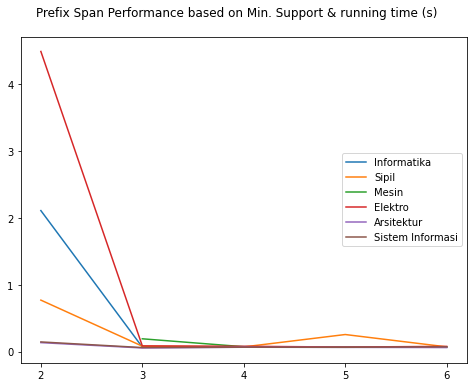

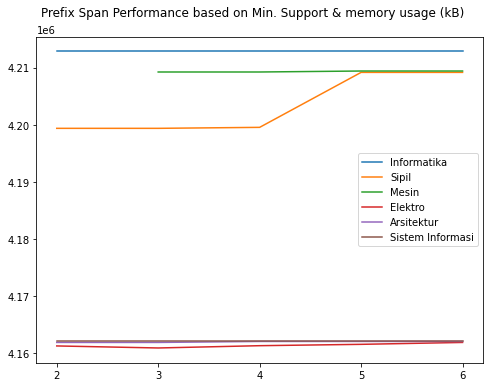

In [36]:
for h in ["running time (s)","memory usage (kB)"]:
    # fig, axs = plt.subplots(2, 3,figsize = (20,15), sharex=True)
    fig = plt.figure(figsize = (8,6))
    for i,jur in enumerate(["Informatika","Sipil","Mesin","Elektro","Arsitektur","Sistem Informasi"]):
        plt.plot(
            df_report[["data","min support",h]][df_report["data"]==jur].set_index("min support").index.astype(str), 
            df_report[["data","min support",h]][df_report["data"]==jur].set_index("min support")[h].values,
            label = jur
        )
        axs[i//3, i%3].set_title(jur)
        axs[i//3, i%3].set_ylim([min(df_report[h]), max(df_report[h]) + max(df_report[h])*0.01])

    for ax in axs.flat:
    ax.set(xlabel='minimum support', ylabel=h)

    for ax in axs.flat:
         ax.label_outer()
    plt.legend(loc="center right")
    fig.suptitle(f'Prefix Span Performance based on Min. Support & {h}', fontsize=12, y=0.95)
    fig.show()